In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CLUSTERDEV GMM MODEL TRAINING

Loading data...
Data shape: (2042, 80)
Columns: ['ClientID', 'CycleNumber', 'Group', 'CycleWithPeakorNot', 'ReproductiveCategory', 'LengthofCycle', 'MeanCycleLength', 'EstimatedDayofOvulation', 'LengthofLutealPhase', 'FirstDayofHigh']...
Training users: 158, rows: 1627
Testing users: 40, rows: 415
Step 1: Preparing user-level features...
User column identified: ClientID
Number of unique users (rows collapsed later): 158
Created 158 user profiles with 47 features

Feature categories created:
- Static demographics: 4
- Cycle statistics: 21
- Health indicators: 3

Step 2: Using 47 features for clustering
Features selected: ['Age', 'AgeM', 'Height', 'Weight', 'Schoolyears', 'Numberpreg', 'Livingkids', 'Miscarriages', 'Abortions', 'Maristatus']...

Step 3: Fitting GMM with BIC selection...
n_components=2, BIC=11325.82
n_components=3, BIC=12309.45
n_components=4, BIC=8817.24
n_components=5, BIC=5368.80
n_components=6, BIC=5279.38

Best model: n_components=6, BI

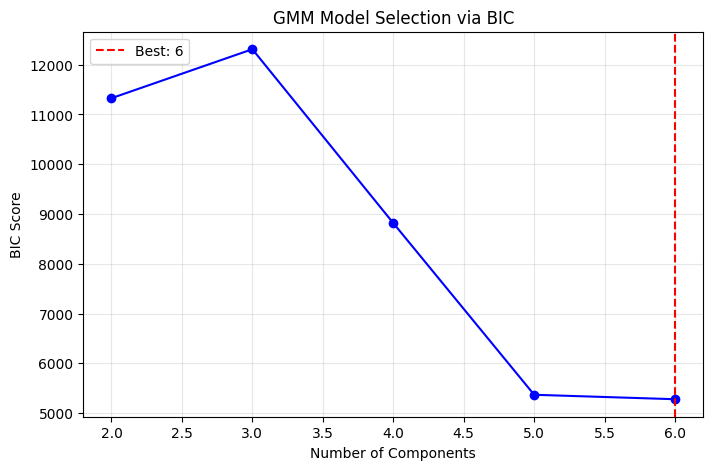


Step 4: Computing ClusterDev scores...

Step 5: Identifying healthy cluster...

Cluster Health Analysis:
   cluster_id  health_score  n_users  pct_users  avg_age  avg_bmi  \
0           0          6.78       15       9.49    26.07    22.72   
1           1         14.04       21      13.29    35.38    28.04   
2           2          6.76       35      22.15    33.97    24.57   
3           3         11.33       28      17.72    19.00    29.09   
4           4         13.04       33      20.89    27.73    23.73   
5           5         17.04       26      16.46    28.31    24.11   

   avg_cycle_length  
0             32.13  
1             28.67  
2             28.70  
3             27.55  
4             29.89  
5             30.82  

Healthiest cluster identified: 2

CLUSTERDEV RESULTS SUMMARY (TRAIN SET)

 Cluster distribution (train):
   Cluster 0: 15 users (9.5%)
   Cluster 1: 21 users (13.3%)
   Cluster 2: 35 users (22.2%)
   Cluster 3: 28 users (17.7%)
   Cluster 4: 33 users (20.

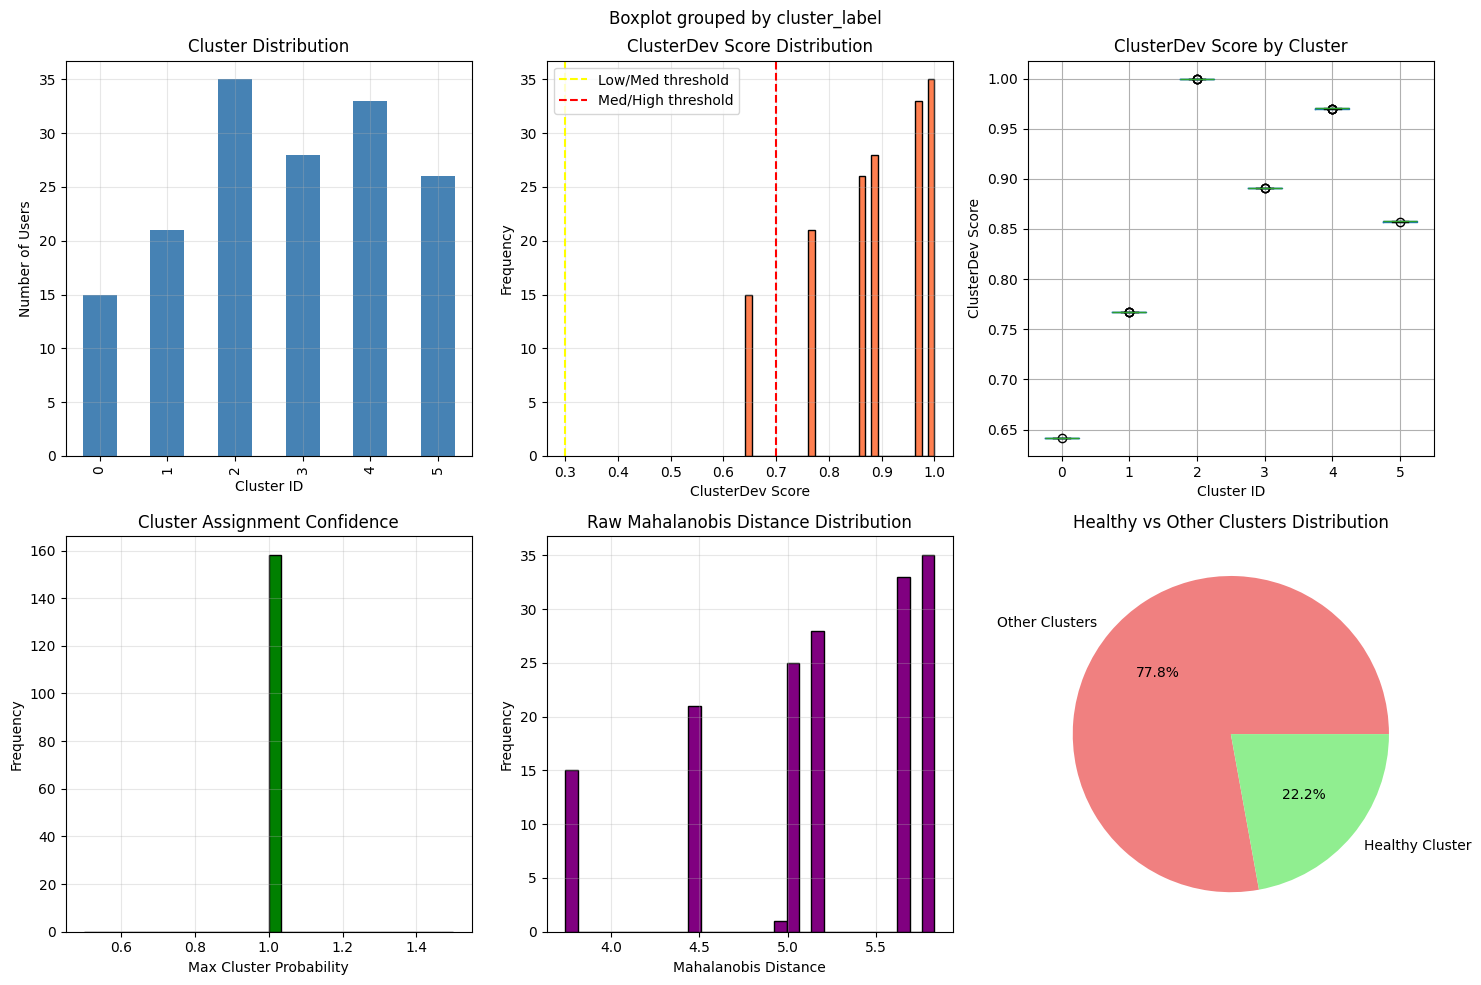


💾 Saving outputs...
Model saved to clusterdev_gmm_model.pkl

FILES SAVED (train set):
- clusterdev_gmm_model.pkl (trained model)
- clusterdev_train_results.csv (user scores)
- user_features_aggregated.csv (aggregated features)
- cluster_health_analysis.csv (cluster health scores)
- clusterdev_analysis.png (visualizations)
- gmm_bic_selection.png (model selection plot)
- clusterdev_summary.json (model summary)

TESTING MODEL ON HELD-OUT USERS (20%)
Testing on 415 rows (40 users)...
User column identified: ClientID
Number of unique users (rows collapsed later): 40

Test results (first 5 users):
          cluster_label  cluster_dev  max_cluster_prob
ClientID                                              
nfp8031               2        0.136               1.0
nfp8042               2        0.269               1.0
nfp8043               2        0.273               1.0
nfp8046               2        0.118               1.0
nfp8047               4        0.418               1.0

 ClusterDev G

In [3]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

class ClusterDevGMM:
    """
    ClusterDev component for PRWI system using Gaussian Mixture Model.
    Measures deviation from healthy lifestyle clusters.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.gmm = None
        self.best_n_components = None
        self.feature_columns = None

    def prepare_features(self, df, user_id_col=None):
      """
      Prepare user-level features for clustering.
      Aggregates cycle-level data to user-level representation.
      Properly handles the multi-cycle-per-user structure.

      user_id_col: optional override of the detected user-id column name.
      """
      # Make a shallow copy to avoid mutating original
      df_work = df.copy()

      # 1) Detect user-id column if not provided
      n_rows = len(df_work)
      detected_user_col = None

      if user_id_col is not None and user_id_col in df_work.columns:
          detected_user_col = user_id_col
      else:
          # Preferred names to check first (common cases)
          preferred_names = [
              'user_id', 'UserID', 'userid', 'user', 'ID', 'id',
              'client', 'Client', 'client_id', 'ClientID', 'Unnamed: 0'
          ]
          for name in preferred_names:
              if name in df_work.columns:
                  detected_user_col = name
                  break

          # If not found, pick a column with relatively small nunique (repeated values)
          if detected_user_col is None:
              col_stats = []
              for col in df_work.columns:
                  try:
                      nunique = df_work[col].nunique(dropna=True)
                  except Exception:
                      nunique = n_rows
                  col_stats.append((col, nunique))
              # Sort by increasing nunique
              col_stats.sort(key=lambda x: x[1])
              # Choose first column whose nunique is >1 and significantly < n_rows
              for col, nunique in col_stats:
                  if nunique > 1 and nunique <= max(1, n_rows * 0.7):
                      # Also prefer columns that are strings (IDs often strings) or integer columns with repeats
                      detected_user_col = col
                      break

      # If still None, fallback to index (but warn)
      if detected_user_col is None:
          if df_work.index.name is not None:
              detected_user_col = df_work.index.name
              df_work = df_work.reset_index()
          else:
              # reset index and use the reset index column (will be named 'index' or 'level_0')
              df_work = df_work.reset_index()
              detected_user_col = df_work.columns[0]
              print(f"[WARN] No clear user-id column detected — using '{detected_user_col}'. If incorrect, pass user_id_col explicitly to prepare_features().")

      print(f"User column identified: {detected_user_col}")
      unique_users = df_work[detected_user_col].unique()
      print(f"Number of unique users (rows collapsed later): {len(unique_users)}")

      # Define feature groups
      static_features = ['Age', 'AgeM', 'Height', 'Weight', 'Schoolyears',
                        'Numberpreg', 'Livingkids', 'Miscarriages', 'Abortions',
                        'Maristatus', 'MaristatusM', 'Yearsmarried',
                        'Religion', 'ReligionM', 'Ethnicity', 'EthnicityM', 'BMI']

      # Cycle-level features to aggregate
      cycle_features = {
          'LengthofCycle': ['mean', 'std', 'min', 'max'],
          'LengthofLutealPhase': ['mean', 'std'],
          'LengthofMenses': ['mean', 'std'],
          'MeanBleedingIntensity': ['mean', 'std'],
          'TotalMensesScore': ['mean', 'std'],
          'TotalNumberofHighDays': ['mean', 'std'],
          'TotalDaysofFertility': ['mean', 'std'],
          'NumberofDaysofIntercourse': ['mean', 'std'],
          'EstimatedDayofOvulation': ['mean', 'std'],
          'TotalNumberofPeakDays': ['mean'
          ]
      }

      # Menses day columns
      menses_cols = [col for col in df_work.columns if 'MensesScoreDay' in col]

      user_features = []

      # Use groupby to iterate per user. This will correctly collect multiple rows per user.
      grouped = df_work.groupby(detected_user_col, sort=False)

      for user_id, user_data in grouped:
          user_row = {detected_user_col: user_id}

          # Static features: take FIRST non-null appearance (preserves fields that only appear once)
          for feat in static_features:
              if feat in user_data.columns:
                  non_null = user_data[feat].dropna()
                  if len(non_null) > 0:
                      # choose first non-null value (keeps the original type if possible)
                      val = non_null.iloc[0]
                      # try cast numeric-like strings to numeric
                      if isinstance(val, str) and val.replace('.', '', 1).replace('-', '', 1).isdigit():
                          try:
                              user_row[feat] = float(val)
                          except:
                              user_row[feat] = val
                      else:
                          user_row[feat] = val

          # Aggregate cycle-level features
          for feat, agg_funcs in cycle_features.items():
              if feat in user_data.columns:
                  values = pd.to_numeric(user_data[feat], errors='coerce').dropna()
                  if len(values) > 0:
                      for func in agg_funcs:
                          col_name = f'{feat}_{func}'
                          if func == 'std':
                              user_row[col_name] = float(values.std()) if len(values) >= 2 else 0.0
                          elif func == 'mean':
                              user_row[col_name] = float(values.mean())
                          elif func == 'min':
                              user_row[col_name] = float(values.min())
                          elif func == 'max':
                              user_row[col_name] = float(values.max())
                          else:
                              # fallback to pandas aggregator
                              try:
                                  user_row[col_name] = float(getattr(values, func)())
                              except Exception:
                                  user_row[col_name] = np.nan

          # Process MensesScore columns - compute extended period metrics
          if menses_cols:
              all_scores = []
              extended_days = 0
              max_period_day = 0
              cycles_count = 0

              for _, cycle in user_data.iterrows():
                  cycles_count += 1
                  for i, col in enumerate(menses_cols, 1):
                      score = pd.to_numeric(cycle.get(col, np.nan), errors='coerce')
                      if pd.notna(score) and score > 0:
                          all_scores.append(score)
                          if i > 7:
                              extended_days += 1
                          if i > max_period_day:
                              max_period_day = i

              if all_scores:
                  user_row['menses_score_mean'] = float(np.mean(all_scores))
                  user_row['menses_score_std'] = float(np.std(all_scores)) if len(all_scores) > 1 else 0.0
                  user_row['extended_period_ratio'] = float(extended_days / max(1, cycles_count))
                  user_row['max_period_day'] = int(max_period_day)

          # Binary features: Breastfeeding, UnusualBleeding
          if 'Breastfeeding' in user_data.columns:
              bf_values = user_data['Breastfeeding'].dropna().astype(str).str.lower()
              if len(bf_values) > 0:
                  val = bf_values.iloc[0]
                  user_row['Breastfeeding'] = int(val in ['y', 'yes', '1', 'true', 't'])

          if 'UnusualBleeding' in user_data.columns:
              ub_values = user_data['UnusualBleeding'].dropna().astype(str).str.lower()
              unusual_count = sum(1 for ub in ub_values if ub in ['y', 'yes', '1', 'true', 't'])
              user_row['unusual_bleeding_ratio'] = float(unusual_count / max(1, len(user_data)))

          # Compute cycle irregularity and count
          if 'LengthofCycle' in user_data.columns:
              cycles = pd.to_numeric(user_data['LengthofCycle'], errors='coerce').dropna()
              if len(cycles) > 1:
                  user_row['cycle_irregularity'] = float(cycles.std() / cycles.mean()) if cycles.mean() > 0 else 0.0
                  user_row['cycle_count'] = int(len(cycles))
              else:
                  user_row['cycle_irregularity'] = 0.0
                  user_row['cycle_count'] = int(len(cycles))

          # BMI if height & weight available (if not already present as static)
          if 'BMI' not in user_row and 'Height' in user_row and 'Weight' in user_row:
              try:
                  height = float(user_row.get('Height'))
                  weight = float(user_row.get('Weight'))
                  if height > 0:
                      user_row['BMI'] = float(weight / ((height / 100.0) ** 2))
              except Exception:
                  pass

          # Reproductive category mode
          if 'ReproductiveCategory' in user_data.columns:
              repro_cats = user_data['ReproductiveCategory'].dropna()
              if len(repro_cats) > 0:
                  try:
                      user_row['repro_category_mode'] = repro_cats.mode().iloc[0]
                  except:
                      user_row['repro_category_mode'] = repro_cats.iloc[0]

          user_features.append(user_row)

      user_df = pd.DataFrame(user_features)
      user_df.set_index(detected_user_col, inplace=True)

      # convert object-like numeric columns to numeric where possible
      for col in user_df.columns:
          if user_df[col].dtype == object:
              try:
                  user_df[col] = pd.to_numeric(user_df[col], errors='coerce')
              except:
                  pass

      return user_df


    def fit_gmm_with_bic(self, X, n_components_range=(2, 6)):
        """
        Fit GMM with different n_components and select best by BIC.
        """
        bic_scores = []
        models = []

        for n in range(n_components_range[0], n_components_range[1] + 1):
            gmm = GaussianMixture(
                n_components=n,
                covariance_type='full',
                max_iter=200,
                n_init=10,
                random_state=self.random_state
            )
            gmm.fit(X)
            bic_scores.append(gmm.bic(X))
            models.append(gmm)
            print(f"n_components={n}, BIC={gmm.bic(X):.2f}")

        # Select model with lowest BIC
        best_idx = np.argmin(bic_scores)
        self.best_n_components = n_components_range[0] + best_idx
        self.gmm = models[best_idx]

        print(f"\nBest model: n_components={self.best_n_components}, BIC={bic_scores[best_idx]:.2f}")

        # Plot BIC scores
        plt.figure(figsize=(8, 5))
        plt.plot(range(n_components_range[0], n_components_range[1] + 1), bic_scores, 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('BIC Score')
        plt.title('GMM Model Selection via BIC')
        plt.axvline(x=self.best_n_components, color='r', linestyle='--', label=f'Best: {self.best_n_components}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig('gmm_bic_selection.png')
        plt.show()

        return bic_scores

    def compute_cluster_dev(self, X, user_ids=None):
        """
        Compute ClusterDev: normalized distance from assigned cluster center.

        Method:
        1. Get cluster assignment and probabilities
        2. Compute Mahalanobis distance to assigned cluster center
        3. Normalize to [0,1] using percentile-based scaling
        """

        # Get cluster assignments and probabilities
        cluster_labels = self.gmm.predict(X)
        cluster_probs = self.gmm.predict_proba(X)

        # Initialize distance array
        distances = np.zeros(X.shape[0])

        # Compute Mahalanobis distance for each point to its assigned cluster
        for i in range(X.shape[0]):
            cluster_id = cluster_labels[i]

            # Get cluster parameters
            mean = self.gmm.means_[cluster_id]
            cov = self.gmm.covariances_[cluster_id]

            # Compute Mahalanobis distance
            diff = X[i] - mean
            try:
                inv_cov = np.linalg.inv(cov + 1e-6 * np.eye(cov.shape[0]))
                distances[i] = np.sqrt(diff @ inv_cov @ diff)
            except:
                # If inversion fails, use pseudo-inverse
                inv_cov = np.linalg.pinv(cov + 1e-6 * np.eye(cov.shape[0]))
                distances[i] = np.sqrt(diff @ inv_cov @ diff)

        # Normalize distances to [0,1] using percentile scaling
        # Use 95th percentile as max to handle outliers
        p95 = np.percentile(distances, 95)
        cluster_dev = np.clip(distances / p95, 0, 1)

        # Create results dataframe
        results = pd.DataFrame({
            'cluster_label': cluster_labels,
            'cluster_dev': cluster_dev,
            'mahalanobis_dist': distances
        })

        # Add cluster probabilities
        for i in range(self.gmm.n_components):
            results[f'cluster_{i}_prob'] = cluster_probs[:, i]

        # Add max probability (confidence in assignment)
        results['max_cluster_prob'] = cluster_probs.max(axis=1)

        if user_ids is not None:
            results.index = user_ids

        return results

    def identify_healthy_cluster(self, results_df, user_features_df):
        """
        Identify which cluster represents the "healthy" profile.
        Based on clinical indicators of reproductive health.
        """

        # Merge results with features
        analysis_df = pd.concat([results_df, user_features_df], axis=1)

        # Define healthy indicators (lower is healthier)
        health_scores = []

        for cluster_id in range(self.gmm.n_components):
            cluster_data = analysis_df[analysis_df['cluster_label'] == cluster_id]

            if len(cluster_data) == 0:
                continue

            score = 0
            weights = {}

            # Cycle regularity (lower std is better)
            if 'LengthofCycle_std' in cluster_data.columns:
                val = cluster_data['LengthofCycle_std'].mean()
                if pd.notna(val):
                    weights['cycle_std'] = val
                    score += val * 2  # Higher weight for regularity

            # Cycle length deviation from normal (28 days)
            if 'LengthofCycle_mean' in cluster_data.columns:
                val = cluster_data['LengthofCycle_mean'].mean()
                if pd.notna(val):
                    weights['cycle_deviation'] = abs(val - 28)
                    score += abs(val - 28)

            # Luteal phase (should be ~14 days)
            if 'LengthofLutealPhase_mean' in cluster_data.columns:
                val = cluster_data['LengthofLutealPhase_mean'].mean()
                if pd.notna(val):
                    weights['luteal_deviation'] = abs(val - 14)
                    score += abs(val - 14)

            # BMI (healthy range 18.5-25)
            if 'BMI' in cluster_data.columns:
                bmi_mean = cluster_data['BMI'].mean()
                if pd.notna(bmi_mean):
                    if bmi_mean < 18.5:
                        weights['bmi_score'] = 18.5 - bmi_mean
                    elif bmi_mean > 25:
                        weights['bmi_score'] = bmi_mean - 25
                    else:
                        weights['bmi_score'] = 0
                    score += weights['bmi_score']

            # Extended periods (lower is better)
            if 'extended_period_ratio' in cluster_data.columns:
                val = cluster_data['extended_period_ratio'].mean()
                if pd.notna(val):
                    weights['extended_periods'] = val * 10  # Scale up for visibility
                    score += val * 10

            # Unusual bleeding (lower is better)
            if 'unusual_bleeding_ratio' in cluster_data.columns:
                val = cluster_data['unusual_bleeding_ratio'].mean()
                if pd.notna(val):
                    weights['unusual_bleeding'] = val * 10
                    score += val * 10

            health_scores.append({
                'cluster_id': int(cluster_id),
                'health_score': float(score),
                'n_users': len(cluster_data),
                'pct_users': len(cluster_data) / len(analysis_df) * 100,
                'avg_age': cluster_data['Age'].mean() if 'Age' in cluster_data.columns else np.nan,
                'avg_bmi': cluster_data['BMI'].mean() if 'BMI' in cluster_data.columns else np.nan,
                'avg_cycle_length': cluster_data['LengthofCycle_mean'].mean() if 'LengthofCycle_mean' in cluster_data.columns else np.nan
            })

        # Lower score = healthier
        health_scores_df = pd.DataFrame(health_scores)
        if len(health_scores_df) > 0:
            healthiest_cluster = int(health_scores_df.loc[health_scores_df['health_score'].idxmin(), 'cluster_id'])
        else:
            healthiest_cluster = 0

        print("\nCluster Health Analysis:")
        print(health_scores_df.round(2))
        print(f"\nHealthiest cluster identified: {healthiest_cluster}")

        return healthiest_cluster, health_scores_df

    def fit(self, df):
        """
        Main fitting pipeline.
        """
        print("Step 1: Preparing user-level features...")
        user_features = self.prepare_features(df)
        print(f"Created {len(user_features)} user profiles with {len(user_features.columns)} features")

        # Display feature summary
        print("\nFeature categories created:")
        print(f"- Static demographics: {sum('Age' in c or 'Weight' in c or 'Height' in c for c in user_features.columns)}")
        print(f"- Cycle statistics: {sum('_mean' in c or '_std' in c for c in user_features.columns)}")
        print(f"- Health indicators: {sum('BMI' in c or 'irregularity' in c or 'bleeding' in c for c in user_features.columns)}")

        # Select features for clustering (numeric only, sufficient coverage)
        numeric_features = user_features.select_dtypes(include=[np.number])
        feature_cols = [col for col in numeric_features.columns
                       if numeric_features[col].notna().sum() > len(numeric_features) * 0.3]
        self.feature_columns = feature_cols

        print(f"\nStep 2: Using {len(feature_cols)} features for clustering")
        print(f"Features selected: {feature_cols[:10]}{'...' if len(feature_cols) > 10 else ''}")

        # Impute missing values
        X_imputed = self.imputer.fit_transform(numeric_features[feature_cols])

        # Scale features
        X_scaled = self.scaler.fit_transform(X_imputed)

        print("\nStep 3: Fitting GMM with BIC selection...")
        bic_scores = self.fit_gmm_with_bic(X_scaled)

        print("\nStep 4: Computing ClusterDev scores...")
        results = self.compute_cluster_dev(X_scaled, user_features.index)

        print("\nStep 5: Identifying healthy cluster...")
        healthy_cluster, health_analysis = self.identify_healthy_cluster(results, user_features)

        # Add healthy cluster indicator
        results['is_healthy_cluster'] = (results['cluster_label'] == healthy_cluster).astype(int)

        return results, user_features, health_analysis

    def transform(self, df):
        """
        Transform new data using fitted model.
        """
        user_features = self.prepare_features(df)
        numeric_features = user_features.select_dtypes(include=[np.number])
        X_imputed = self.imputer.transform(numeric_features[self.feature_columns])
        X_scaled = self.scaler.transform(X_imputed)
        results = self.compute_cluster_dev(X_scaled, user_features.index)
        return results

    def save_model(self, filepath='clusterdev_gmm_model.pkl'):
        """
        Save the fitted model and preprocessors.
        """
        model_data = {
            'gmm': self.gmm,
            'scaler': self.scaler,
            'imputer': self.imputer,
            'feature_columns': self.feature_columns,
            'best_n_components': self.best_n_components
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath='clusterdev_gmm_model.pkl'):
        """
        Load a saved model.
        """
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        self.gmm = model_data['gmm']
        self.scaler = model_data['scaler']
        self.imputer = model_data['imputer']
        self.feature_columns = model_data['feature_columns']
        self.best_n_components = model_data['best_n_components']
        print(f"Model loaded from {filepath}")


# Main execution code
if __name__ == "__main__":

    # Load your data
    print("="*60)
    print("CLUSTERDEV GMM MODEL TRAINING")
    print("="*60)
    print("\nLoading data...")
    df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData 3.csv')

    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")

    # ====================================================
    # Train/Test split at user level (80/20)
    # ====================================================
    from sklearn.model_selection import train_test_split

    # Detect user ID column
    user_id_col = 'ClientID' if 'ClientID' in df.columns else (
        'Unnamed: 0' if 'Unnamed: 0' in df.columns else None
    )
    if user_id_col is None:
        raise ValueError("No user identifier column found in dataset.")

    unique_users = df[user_id_col].unique()
    train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

    train_df = df[df[user_id_col].isin(train_users)].copy()
    test_df = df[df[user_id_col].isin(test_users)].copy()

    print(f"Training users: {len(train_users)}, rows: {len(train_df)}")
    print(f"Testing users: {len(test_users)}, rows: {len(test_df)}")

    # Initialize and fit ClusterDev model on TRAIN set
    cluster_model = ClusterDevGMM(random_state=42)

    try:
        # Fit the model
        results, user_features, health_analysis = cluster_model.fit(train_df)

        # Display results
        print("\n" + "="*60)
        print("CLUSTERDEV RESULTS SUMMARY (TRAIN SET)")
        print("="*60)

        print(f"\n Cluster distribution (train):")
        cluster_dist = results['cluster_label'].value_counts().sort_index()
        for cluster_id, count in cluster_dist.items():
            pct = count / len(results) * 100
            print(f"   Cluster {cluster_id}: {count} users ({pct:.1f}%)")

        print(f"\nClusterDev statistics (train):")
        print(results['cluster_dev'].describe().round(3))

        print("\n Risk stratification (train):")
        print(f"   Low risk (ClusterDev < 0.3): {(results['cluster_dev'] < 0.3).sum()} users")
        print(f"   Medium risk (0.3 ≤ ClusterDev < 0.7): {((results['cluster_dev'] >= 0.3) & (results['cluster_dev'] < 0.7)).sum()} users")
        print(f"   High risk (ClusterDev ≥ 0.7): {(results['cluster_dev'] >= 0.7).sum()} users")

        print("\n Sample train results (first 10 users):")
        display_cols = ['cluster_label', 'cluster_dev', 'max_cluster_prob', 'is_healthy_cluster']
        print(results[display_cols].head(10).round(3))

        # Visualize results (train)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # 1. Cluster distribution
        cluster_dist.plot(kind='bar', ax=axes[0, 0], color='steelblue')
        axes[0, 0].set_xlabel('Cluster ID')
        axes[0, 0].set_ylabel('Number of Users')
        axes[0, 0].set_title('Cluster Distribution')
        axes[0, 0].grid(True, alpha=0.3)

        # 2. ClusterDev distribution
        axes[0, 1].hist(results['cluster_dev'], bins=30, edgecolor='black', color='coral')
        axes[0, 1].axvline(x=0.3, color='yellow', linestyle='--', label='Low/Med threshold')
        axes[0, 1].axvline(x=0.7, color='red', linestyle='--', label='Med/High threshold')
        axes[0, 1].set_xlabel('ClusterDev Score')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('ClusterDev Score Distribution')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. ClusterDev by cluster (boxplot)
        results.boxplot(column='cluster_dev', by='cluster_label', ax=axes[0, 2])
        axes[0, 2].set_xlabel('Cluster ID')
        axes[0, 2].set_ylabel('ClusterDev Score')
        axes[0, 2].set_title('ClusterDev Score by Cluster')
        plt.sca(axes[0, 2])
        plt.xticks(rotation=0)

        # 4. Cluster assignment confidence
        axes[1, 0].hist(results['max_cluster_prob'], bins=30, edgecolor='black', color='green')
        axes[1, 0].set_xlabel('Max Cluster Probability')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Cluster Assignment Confidence')
        axes[1, 0].grid(True, alpha=0.3)

        # 5. Mahalanobis distance distribution
        axes[1, 1].hist(results['mahalanobis_dist'], bins=30, edgecolor='black', color='purple')
        axes[1, 1].set_xlabel('Mahalanobis Distance')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Raw Mahalanobis Distance Distribution')
        axes[1, 1].grid(True, alpha=0.3)

        # 6. Health cluster distribution
        health_dist = results.groupby('is_healthy_cluster').size()
        axes[1, 2].pie(health_dist.values, labels=['Other Clusters', 'Healthy Cluster'],
                      autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
        axes[1, 2].set_title('Healthy vs Other Clusters Distribution')

        plt.tight_layout()
        plt.savefig('clusterdev_analysis.png', dpi=100, bbox_inches='tight')
        plt.show()

        # Save the model and train results
        print("\n💾 Saving outputs...")
        cluster_model.save_model('clusterdev_gmm_model.pkl')
        results.to_csv('clusterdev_train_results.csv')
        user_features.to_csv('user_features_aggregated.csv')
        health_analysis.to_csv('cluster_health_analysis.csv')

        # Create a summary report (train)
        summary = {
            'model_type': 'Gaussian Mixture Model',
            'n_components': cluster_model.best_n_components,
            'n_users': len(results),
            'n_features': len(cluster_model.feature_columns),
            'healthiest_cluster': int(health_analysis.loc[health_analysis['health_score'].idxmin(), 'cluster_id']),
            'mean_cluster_dev': float(results['cluster_dev'].mean()),
            'std_cluster_dev': float(results['cluster_dev'].std()),
            'high_risk_users': int((results['cluster_dev'] >= 0.7).sum()),
            'features_used': cluster_model.feature_columns
        }

        with open('clusterdev_summary.json', 'w') as f:
            import json
            json.dump(summary, f, indent=2, default=str)

        print("\n" + "="*60)
        print("FILES SAVED (train set):")
        print("- clusterdev_gmm_model.pkl (trained model)")
        print("- clusterdev_train_results.csv (user scores)")
        print("- user_features_aggregated.csv (aggregated features)")
        print("- cluster_health_analysis.csv (cluster health scores)")
        print("- clusterdev_analysis.png (visualizations)")
        print("- gmm_bic_selection.png (model selection plot)")
        print("- clusterdev_summary.json (model summary)")
        print("="*60)

        # ====================================================
        # Test the model on HELD-OUT TEST SET (20%)
        # ====================================================
        print("\n" + "="*60)
        print("TESTING MODEL ON HELD-OUT USERS (20%)")
        print("="*60)

        print(f"Testing on {len(test_df)} rows ({len(test_users)} users)...")
        test_results = cluster_model.transform(test_df)

        print("\nTest results (first 5 users):")
        print(test_results[['cluster_label', 'cluster_dev', 'max_cluster_prob']].head().round(3))

        # Save test results separately
        test_results.to_csv('clusterdev_test_results.csv')

        print("\n ClusterDev GMM implementation complete!")
        print("="*60)

    except Exception as e:
        print(f"\n Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\nPlease check your data format and try again.")


Clustering Evaluation Metrics
Silhouette Score: 0.021
Davies-Bouldin Index (lower=better): 2.842
Calinski-Harabasz Index (higher=better): 8.832


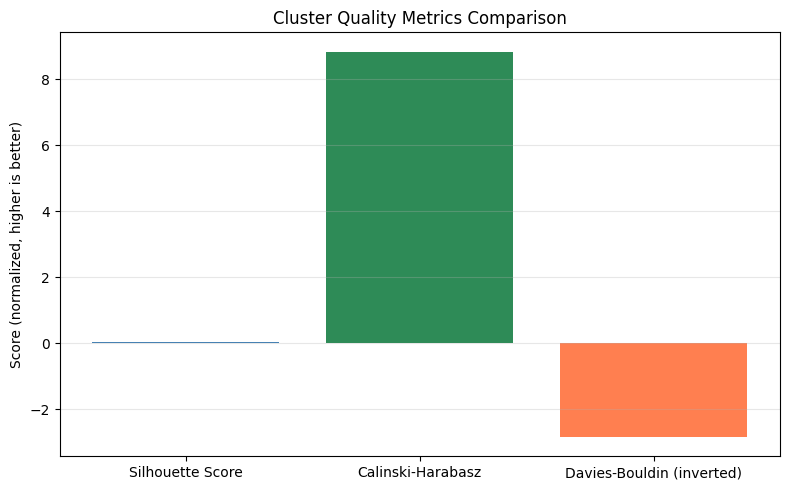

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# Features used in clustering
feature_cols = cluster_model.feature_columns
X = user_features[feature_cols].copy()

# Handle missing values (choose strategy)
X = X.fillna(X.mean())   # Option 1: fill NaN with column mean
# X = X.dropna()         # Option 2: drop users with NaN (if you prefer strict filtering)

# Re-scale (same way as training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster labels from results (keep alignment with X)
y_pred = results.loc[X.index, 'cluster_label'].values

# --- Clustering Evaluation Metrics ---
sil_score = silhouette_score(X_scaled, y_pred)
dbi_score = davies_bouldin_score(X_scaled, y_pred)
ch_score = calinski_harabasz_score(X_scaled, y_pred)

print("Clustering Evaluation Metrics")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index (lower=better): {dbi_score:.3f}")
print(f"Calinski-Harabasz Index (higher=better): {ch_score:.3f}")

# --- Visualization: Bar chart comparison ---
metrics = {
    "Silhouette Score": sil_score,
    "Calinski-Harabasz": ch_score,
    "Davies-Bouldin (inverted)": -dbi_score   # negate so all "higher=better"
}

plt.figure(figsize=(8,5))
plt.bar(metrics.keys(), metrics.values(), color=['steelblue','seagreen','coral'])
plt.ylabel("Score (normalized, higher is better)")
plt.title("Cluster Quality Metrics Comparison")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("cluster_quality_metrics.png", dpi=100)
plt.show()


Cluster visualization plot saved as 'gmm_clusters.png'


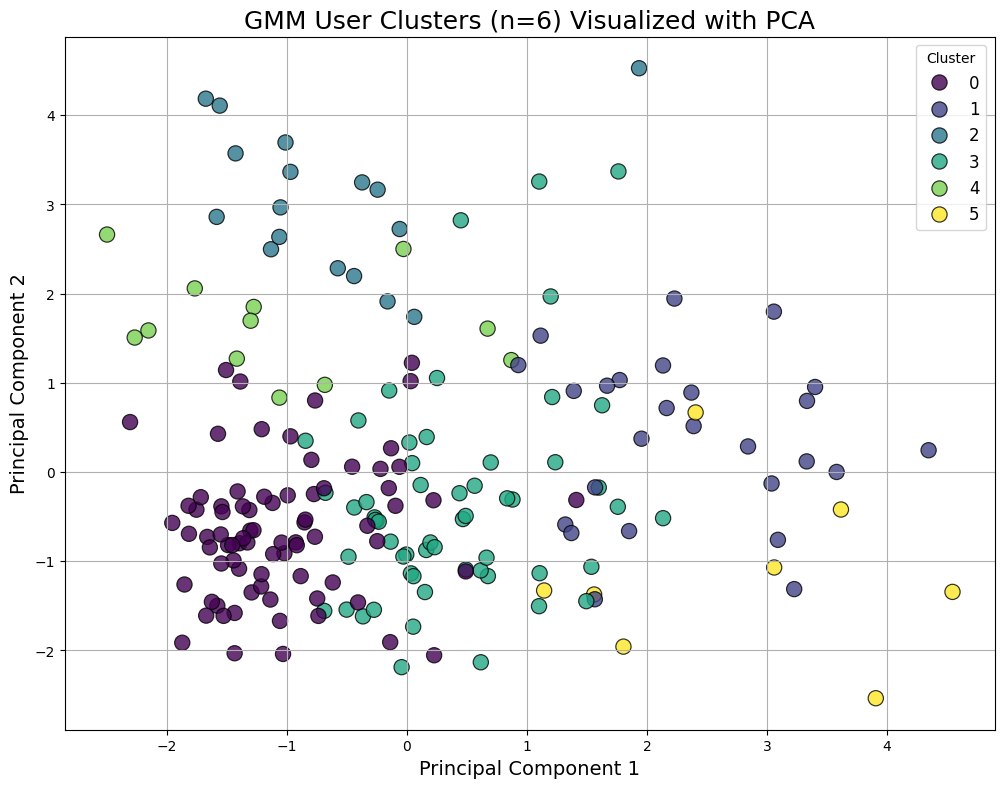

In [5]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# --- 1. Data Loading and Preprocessing ---
# This mirrors the setup in your ClusterDev.ipynb notebook.
# Load the augmented dataset
try:
    # Ensure 'FedCycleData 3.csv' is accessible in your environment
    df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData 3.csv')
except FileNotFoundError:
    print("Error: 'FedCycleData 3.csv' not found. Please ensure the dataset is in the correct directory.")
    # Exit gracefully if the file isn't found
    exit()

# --- FIX: Convert relevant columns to numeric type ---
# Define the columns that should be numeric for the aggregation step
numeric_cols_for_agg = [
    'LengthofCycle', 'MeanCycleLength', 'LengthofLutealPhase',
    'TotalMensesScore', 'BMI', 'Age', 'UnusualBleeding', 'CycleWithPeakorNot'
]

# Loop through columns and force conversion to numeric, coercing errors
for col in numeric_cols_for_agg:
    df[col] = pd.to_numeric(df[col], errors='coerce')


# Define the function to aggregate data at the user level
def compute_user_aggregates(df):
    agg_funcs = {
        'LengthofCycle': ['mean', 'std'],
        'MeanCycleLength': ['mean', 'std'],
        'LengthofLutealPhase': ['mean', 'std'],
        'TotalMensesScore': ['mean'],
        'BMI': ['mean'],
        'Age': ['mean'],
        'UnusualBleeding': ['sum'],
        'CycleWithPeakorNot': [lambda x: (x == 0).sum()] # Count anovulatory cycles
    }
    user_df = df.groupby('ClientID').agg(agg_funcs).reset_index()
    user_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] else col[0] for col in user_df.columns.values]
    user_df = user_df.rename(columns={'CycleWithPeakorNot_<lambda>': 'AnovulatoryCycles_sum'})
    return user_df

user_df = compute_user_aggregates(df)

# Select features for clustering
feature_columns = [col for col in user_df.columns if col not in ['ClientID']]
X = user_df[feature_columns]

# Impute and Scale the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- 2. GMM Training ---
# Train the GMM with 6 components, as determined by the BIC score analysis
n_clusters = 6
gmm = GaussianMixture(n_components=n_clusters, random_state=42, covariance_type='full')
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

# --- 3. PCA for Dimensionality Reduction ---
# Apply PCA to reduce the feature space to 2 dimensions for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 4. Plotting ---
# Create a DataFrame for the PCA results and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = cluster_labels

# Create the scatter plot using Seaborn
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='Cluster',
    data=pca_df,
    palette='viridis', # A visually distinct color palette
    s=120, # Marker size
    alpha=0.8,
    edgecolor='k' # Black edge on markers for better visibility
)

# Add titles, labels, and legend
plt.title(f'GMM User Clusters (n={n_clusters}) Visualized with PCA', fontsize=18)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)

# --- 5. Save the Figure ---
# Save the plot to a high-resolution file
output_filename = 'gmm_clusters.png'
plt.savefig(output_filename, dpi=300)

print(f"Cluster visualization plot saved as '{output_filename}'")
plt.show()

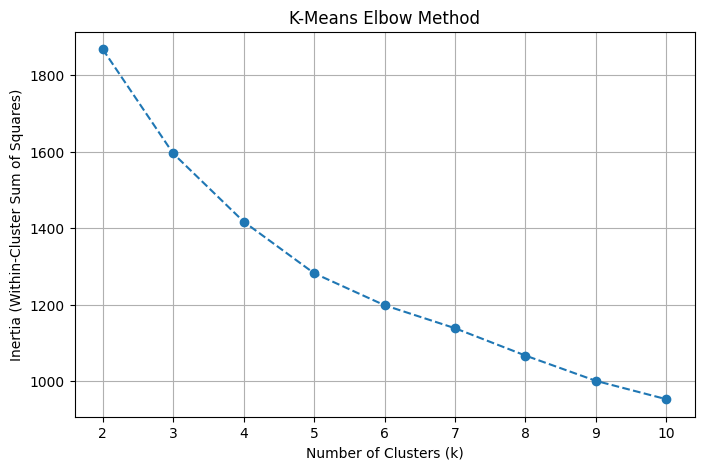

--- K-Means Clustering Evaluation ---
Optimal number of clusters (k) chosen: 6
Silhouette Score for K-Means: 0.18


In [6]:
# --- Code Block for K-Means Comparison ---

# 1. Import the necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 2. Find the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(2, 11) # Test for 2 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('K-Means Elbow Method')
plt.grid(True)
plt.show()

# --- From the plot, choose the optimal 'k' where the elbow occurs ---
optimal_k = 6

# 3. Train the final K-Means model with the optimal k
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_model.fit(X_scaled)
kmeans_labels = kmeans_model.predict(X_scaled)

# 4. Evaluate the K-Means model using the Silhouette Score
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)

print("--- K-Means Clustering Evaluation ---")
print(f"Optimal number of clusters (k) chosen: {optimal_k}")
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.2f}")

Cluster evaluation plot saved as 'GMM_Elbow.png'


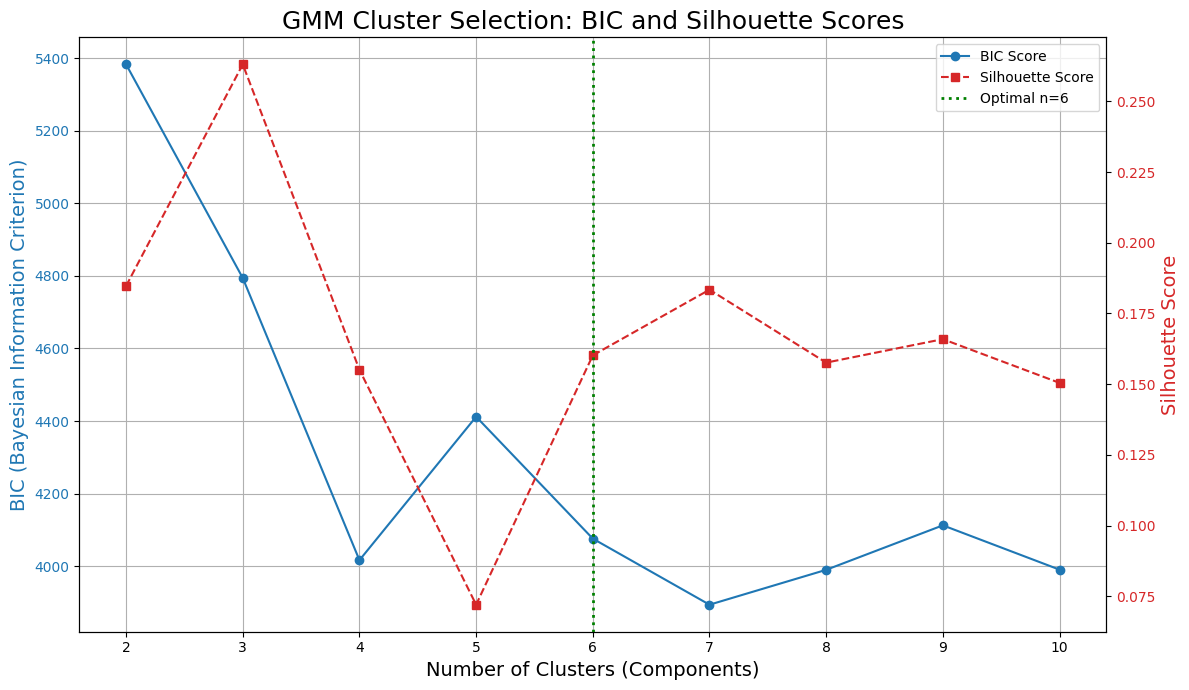

In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# --- 1. Data Loading and Preprocessing (Same as your notebook) ---
try:
    # Ensure 'FedCycleData 3.csv' is accessible in your environment
    df = pd.read_csv('/content/drive/MyDrive/Capstone/FedCycleData 3.csv')
except FileNotFoundError:
    print("Error: 'FedCycleData 3.csv' not found. Please ensure the dataset is in the correct directory.")
    exit()

def compute_user_aggregates(df):
    numeric_cols_for_agg = [
        'LengthofCycle', 'MeanCycleLength', 'LengthofLutealPhase',
        'TotalMensesScore', 'BMI', 'Age', 'UnusualBleeding', 'CycleWithPeakorNot'
    ]
    for col in numeric_cols_for_agg:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    agg_funcs = {
        'LengthofCycle': ['mean', 'std'],
        'MeanCycleLength': ['mean', 'std'],
        'LengthofLutealPhase': ['mean', 'std'],
        'TotalMensesScore': ['mean'],
        'BMI': ['mean'],
        'Age': ['mean'],
        'UnusualBleeding': ['sum'],
        'CycleWithPeakorNot': [lambda x: (x == 0).sum()]
    }
    user_df = df.groupby('ClientID').agg(agg_funcs).reset_index()
    user_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] else col[0] for col in user_df.columns.values]
    user_df = user_df.rename(columns={'CycleWithPeakorNot_<lambda>': 'AnovulatoryCycles_sum'})
    return user_df

user_df = compute_user_aggregates(df)
feature_columns = [col for col in user_df.columns if col not in ['ClientID']]
X = user_df[feature_columns]
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# --- 2. Calculate BIC and Silhouette Scores for a Range of Clusters ---
n_components_range = range(2, 11)
bic_scores = []
silhouette_scores = []

for n_components in n_components_range:
    # Train GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type='full')
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    # Calculate and store scores
    bic_scores.append(gmm.bic(X_scaled))
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# --- 3. Plotting the Dual-Axis Chart ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot BIC score on the primary y-axis (ax1)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (Components)', fontsize=14)
ax1.set_ylabel('BIC (Bayesian Information Criterion)', color=color, fontsize=14)
ax1.plot(n_components_range, bic_scores, color=color, marker='o', linestyle='-', label='BIC Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis (ax2) sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color, fontsize=14)
ax2.plot(n_components_range, silhouette_scores, color=color, marker='s', linestyle='--', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Add a vertical line at the optimal number of clusters (n=6)
optimal_clusters = 6
plt.axvline(x=optimal_clusters, color='green', linestyle=':', linewidth=2, label=f'Optimal n={optimal_clusters}')

# Final touches
plt.title('GMM Cluster Selection: BIC and Silhouette Scores', fontsize=18)
fig.tight_layout()
# Add a single legend for all lines
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# --- 4. Save the Figure ---
output_filename = 'GMM_Elbow.png'
plt.savefig(output_filename, dpi=300)

print(f"Cluster evaluation plot saved as '{output_filename}'")
plt.show()